Lets look at some shapes

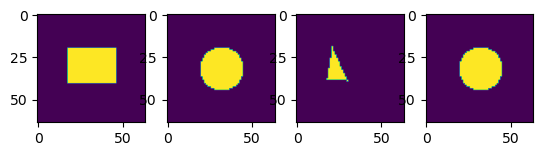

In [1]:
import matplotlib.pyplot as plt
from utils import shapes

img_size = 64
S = shapes(img_size=img_size, noise_lvl=0.05)
fig, ax = plt.subplots(1,4)
shape_names = ['rectangle', 'circle', 'triangle', 'ellipse']
for i in range(4):
    ax[i].imshow(S.get_shape(shape_names[i]))

Let's get the model

In [2]:
from models import UNet
model = UNet()
best_model = UNet()
best_loss = float('inf')

In [31]:
import numpy as np
import torch
import torch.nn as nn
from operators import Radon

num_thetas = 10
min_angle = 0
max_angle = 90
theta = np.linspace(min_angle, max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

loss_fct = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0)


noise_lvl = 0.02
def noise(x):
    return np.random.normal(0, noise_lvl, size=x.shape)

In [32]:
def get_data(batch_size, train_shape):
    x_recon = np.zeros((batch_size, 1, img_size, img_size))
    x = np.zeros((batch_size, 1, img_size, img_size))

    # set real images and inputs
    for i in range(batch_size):
        x[i,0,...] = S.get_shape(train_shape)
        sinogram =  R(x[i,0,...])
        sinogram += noise(sinogram)
        x_recon[i, 0, ...] = R.inverse(sinogram)

    return x_recon, torch.Tensor(x)

In [40]:
def train_step(get_data, batch_size=5, train_shape='rectangle'):
    opt.zero_grad()
    x_recon, x = get_data(batch_size, train_shape)
    
    x_model = model(x_recon)
    loss = loss_fct(x_model, x)
    loss.backward()
    opt.step()
    scheduler.step()
    
    loss1 = loss.item()
    loss2 = loss_fct(torch.Tensor(x_recon), torch.Tensor(x)).item()

    if loss1 < best_loss:
        best_model.load_state_dict(model.state_dict())
    print(30*'-')
    print('Epoch: ' + str(epoch))
    print('Current Loss:' + str(loss1))
    print('IRadon Loss:' + str(loss2))
    for param_group in opt.param_groups:
        print('Current lr:' + str(param_group['lr']))

Let's train the net

In [6]:
train_shape = 'circle'
batch_size = 5
epochs = 400

for epoch in range(epochs):
    train_step(get_data, batch_size=batch_size, train_shape=train_shape)

------------------------------
Epoch: 0
Current Loss:0.13388986885547638
IRadon Loss:0.15134425461292267
Current lr:0.0009755282581475768
------------------------------
Epoch: 1
Current Loss:0.10424051433801651
IRadon Loss:0.14527034759521484
Current lr:0.0009045084971874736
------------------------------
Epoch: 2
Current Loss:0.08896356076002121
IRadon Loss:0.1566735953092575
Current lr:0.0007938926261462366
------------------------------
Epoch: 3
Current Loss:0.06923777610063553
IRadon Loss:0.15888170897960663
Current lr:0.0006545084971874737
------------------------------
Epoch: 4
Current Loss:0.056506939232349396
IRadon Loss:0.15394064784049988
Current lr:0.0005
------------------------------
Epoch: 5
Current Loss:0.04387475922703743
IRadon Loss:0.14732582867145538
Current lr:0.00034549150281252633
------------------------------
Epoch: 6
Current Loss:0.044705189764499664
IRadon Loss:0.1590280383825302
Current lr:0.0002061073738537635
------------------------------
Epoch: 7
Current 

In [7]:
## save the model
save_model = False
if save_model:
    torch.save(model.state_dict(), train_shape + '.pt')

In [8]:
load_model = True
if load_model:
    model.load_state_dict(torch.load('circle2.pt'))

Let's look at the results

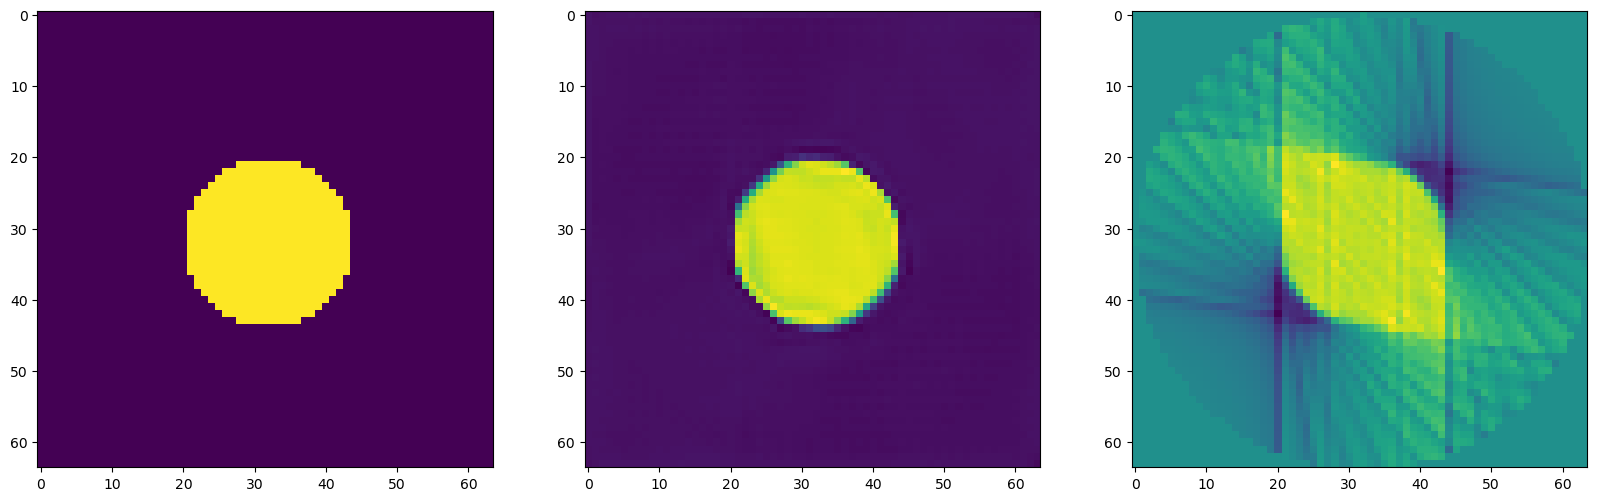

In [13]:
# %% Test
from utils import get_phantom
img_size_test=64
S_test = shapes(img_size=img_size_test)

min_angle = 0
max_angle = 90
theta = np.linspace(min_angle,max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

test_shape = 'rectangle'
test_shape = 'circle'
#test_shape = 'triangle'
#test_shape = 'ellipse'
I = S_test.get_shape(test_shape)
#I = get_phantom(img_size_test)

I_sino = R(I)
#I_sino += noise(I_sino)
recon = R.inv(I_sino)
model_recon = model(recon)


fig, ax = plt.subplots(1,3, figsize = (20,15))
ax[0].imshow(I)
ax[1].imshow(model_recon.detach()[0,0,...])
ax[2].imshow(recon)

# Train a Denoising Task

In [37]:
num_thetas = 30
min_angle = 0
max_angle = 180
theta = np.linspace(min_angle, max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)
noise_lvl = 0.02
def noise(x):
    return np.random.normal(0, noise_lvl, size=x.shape)

def get_data(batch_size, train_shape):
    x_recon = np.zeros((batch_size, 1, img_size, img_size))
    x = np.zeros((batch_size, 1, img_size, img_size))

    # set real images and inputs
    for i in range(batch_size):
        x[i,0,...] = S.get_shape(train_shape)
        sinogram =  R(x[i,0,...])
        sinogram += noise(sinogram)
        x_recon[i, 0, ...] = R.inverse(sinogram)

    return x_recon, torch.Tensor(x)

Look at the data

Text(0.5, 1.0, 'Original')

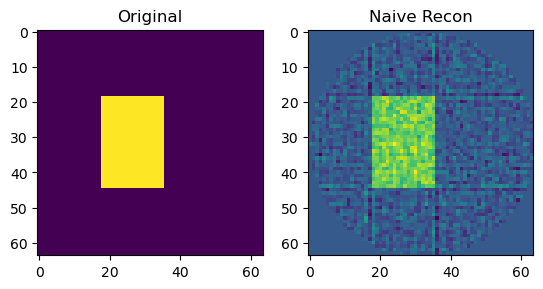

In [28]:
x_recon, x = get_data(5, 'rectangle')

fig, ax = plt.subplots(1,2)
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

# Train again

In [58]:
model = UNet()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0)

In [45]:
train_shape = 'circle'
batch_size = 5
epochs = 20

for epoch in range(epochs):
    train_step(get_data, batch_size=batch_size, train_shape=train_shape)

------------------------------
Epoch: 0
Current Loss:0.19516043365001678
IRadon Loss:0.020390575751662254
Current lr:0.0009755282581475768
------------------------------
Epoch: 1
Current Loss:0.13352249562740326
IRadon Loss:0.0199366994202137
Current lr:0.0009045084971874736
------------------------------
Epoch: 2
Current Loss:0.11342503875494003
IRadon Loss:0.019913295283913612
Current lr:0.0007938926261462366
------------------------------
Epoch: 3
Current Loss:0.0529279001057148
IRadon Loss:0.019900213927030563
Current lr:0.0006545084971874737
------------------------------
Epoch: 4
Current Loss:0.09210554510354996
IRadon Loss:0.01949903555214405
Current lr:0.0005
------------------------------
Epoch: 5
Current Loss:0.03679271414875984
IRadon Loss:0.01928972639143467
Current lr:0.00034549150281252633
------------------------------
Epoch: 6
Current Loss:0.024528250098228455
IRadon Loss:0.019993765279650688
Current lr:0.0002061073738537635
------------------------------
Epoch: 7
Curre

# How well does it work?

Text(0.5, 1.0, 'Original')

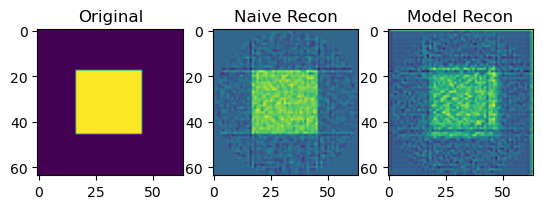

In [59]:
x_recon, x = get_data(5, 'rectangle')

fig, ax = plt.subplots(1,3)
ax[2].imshow(model(x_recon).detach()[0,0,...])
ax[2].set_title('Model Recon')
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

In [48]:
from optimizers import optimizer
from operators import soft_shrinkage

class proxGD(optimizer):
    def __init__(self, A, x, y, t=0.1, lamda=1.0, prox=None, **kwargs):
        super().__init__(**kwargs)
        self.A = A
        self.x = x
        self.y = y
        self.lamda = lamda
        self.t = t
        self.prox = prox if not prox is None else soft_shrinkage
    
    def step(self,):
        grad = self.A.adjoint(self.A(self.x) - self.y)
        lin_up = self.x - 2 * self.t * grad
        self.x = self.prox(lin_up, self.lamda * self.t)

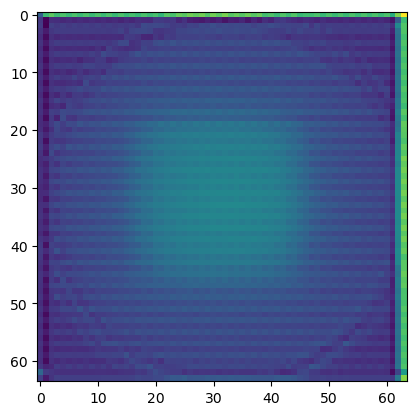

In [62]:
def model_prox(x, lamda):
    return model(x).detach().numpy()[0,0,...]

x0 = x_recon[0,0,...]
sinogram = R(x0)
pGD = proxGD(R, x0, sinogram, t=1.1, lamda=0.1, verbosity=0, prox=model_prox, max_it=4)
pGD.solve()
plt.imshow(pGD.x)